In [2]:
from generate_maps import load_s3dis_point_cloud, get_topologial_map

file_path = 'data/noXYZ_area_3_no_xyz/area_3/3d/pointcloud.mat'  
point_sum_points, point_sum_colors, scene_names = load_s3dis_point_cloud(file_path)
print("success load!")


Keys in the .mat file: ['Area_3']
Processing conferenceRoom_1...
Processing hallway_1...
Processing hallway_2...
Processing hallway_3...
Processing hallway_4...
Processing hallway_5...
Processing hallway_6...
Processing lounge_1...
Processing lounge_2...
Processing office_1...
Processing office_2...
Processing office_3...
Processing office_4...
Processing office_5...
Processing office_6...
Processing office_7...
Processing office_8...
Processing office_9...
Processing office_10...
Processing storage_1...
Processing storage_2...
Processing WC_1...
Processing WC_2...
success load!


In [2]:
print(point_sum_points[0].shape)

(1266990, 3)


In [3]:
import generate_maps
import importlib
importlib.reload(generate_maps)

top_view_map, obstacle_map, separate_obstacle_map, all_centers = generate_maps.get_top_view_map(point_sum_points, point_sum_colors, scene_names)



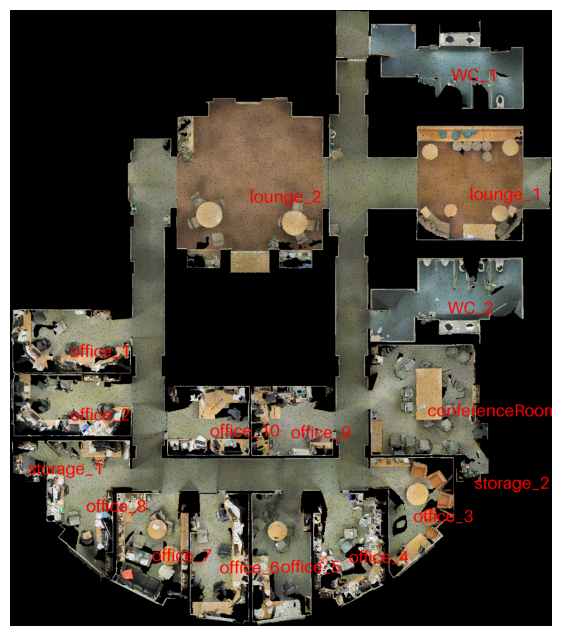

(1463, 1287, 3)


In [4]:
import path_finding
importlib.reload(path_finding)
import matplotlib.pyplot as plt

# img = Image.fromarray(top_view_map)
# img.save("map_with_path/area_3/full_map.png")
# plt.figure(figsize=(10, 8)) 
# plt.imshow(top_view_map)
# plt.axis('off')  # 隐藏坐标轴
# plt.show()

img = path_finding.write_scene_name(top_view_map, all_centers)
plt.figure(figsize=(10, 8)) 
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.show()
print(top_view_map.shape)

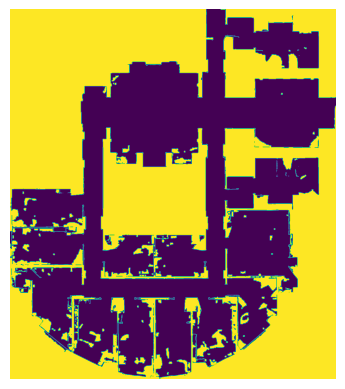

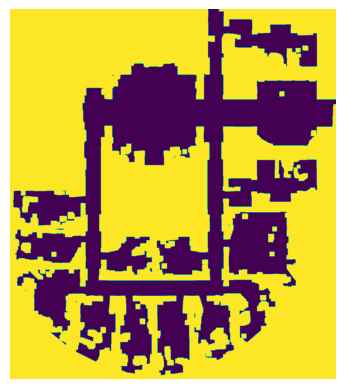

In [5]:
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15, 15))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)


plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [6]:

# build topo map
# G = get_topologial_map(point_sum_points, scene_names)
# graph_show(G)


success load!


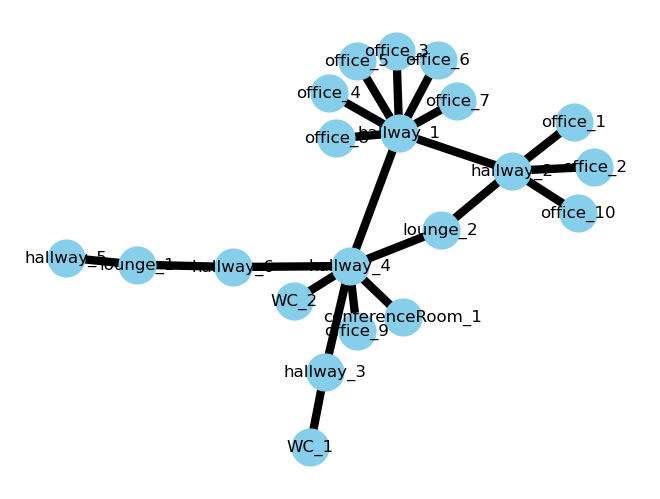

In [6]:
import os
import numpy as np
import pickle

filename = "3"

# print('Saving model to {}...'.format("saved_maps/"))
# if not os.path.exists("saved_maps/"):
#     os.makedirs("saved_maps/")
    
# graph_serialized = pickle.dumps(G)
# np.savez("saved_maps/" + filename +'_arrays.npz', graph=graph_serialized)
# print('Finished.')

file_path = f"saved_maps/{filename}_arrays.npz"  
data = np.load(file_path, allow_pickle=True)
graph_serialized = data['graph'].item()
G_loaded = pickle.loads(graph_serialized)
print("success load!")

path_finding.graph_show(G_loaded)

In [7]:
import networkx as nx
import cv2
import numpy as np
from io import BytesIO

importlib.reload(path_finding)

# all possible topo path searching

def get_all_candidate_maps(source_node, target_node):
    all_topo_paths = path_finding.get_all_simple_paths(G_loaded, source_node, target_node)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph(all_topo_paths, obstacle_map, all_centers)

    save_directory = f"map_with_path/area_{filename}/{source_node}-{target_node}/"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # show paths in map
    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = top_view_map.copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number(map_with_path, i)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像.
        map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    return candidate_map_list, all_geo_paths

In [8]:
importlib.reload(path_finding)
from PIL import Image

def get_metric(source_node, target_node, all_geo_paths):
    evaluation_map = path_finding.get_evaulation_map(separate_obstacle_map, source_node, target_node, scene_names, 15)

    office_obstacle_map_array = np.array(separate_obstacle_map)
    office_obstacle_map = np.max(office_obstacle_map_array, axis=0)

    # evaluation_map = Image.fromarray(evaluation_map)
    # evaluation_map.save(save_directory+f"metric.png")
    # plt.imshow(evaluation_map)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()

    # plt.imshow(gaussian_modulation)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()
    privacy_value_list = []
    distance_list = []
    for i, geo_path in enumerate(all_geo_paths):
        x_indices, y_indices = zip(*geo_path)
        # print(gaussian_modulation[x_indices[0], y_indices[0]])
        print(sum(evaluation_map[x_indices, y_indices]))
        print("distance: ", len(geo_path))
        privacy_value_list.append(sum(evaluation_map[x_indices, y_indices]))
        distance_list.append(len(geo_path))
        
    return privacy_value_list, distance_list

All paths from node office_1 to node office_3 :
2 ['office_1', 'office_3']
4 ['office_1', 'lounge_2', 'hallway_4', 'office_3']
2
['office_1', 'office_3']
['office_1', 'lounge_2', 'hallway_4', 'office_3']


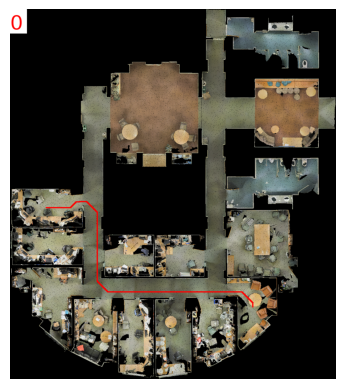

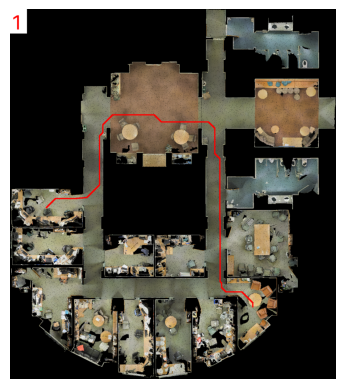

689.8301491009724
distance:  1105
277.3497170649805
distance:  1662
gpt-4o response: 
{
    "observation": "Path 0 travels through a hallway lined with offices, while Path 1 detours around the central open area and avoids passing adjacent to as many individual office spaces.",
    "reason": "Although Path 1 crosses the larger, open space, fewer workspaces line that route, reducing intrusions. This helps maintain the document’s privacy and minimizes interference with people working in offices.",
    "self-critique": "While Path 0 might appear more direct, it exposes the transport to more potential interruptions and privacy concerns. Path 1 provides a more suitable route given the classified nature of the file.",
    "path_id": "1"
}


ValueError: malformed node or string: {'observation': 'Path 0 travels through a hallway lined with offices, while Path 1 detours around the central open area and avoids passing adjacent to as many individual office spaces.', 'reason': 'Although Path 1 crosses the larger, open space, fewer workspaces line that route, reducing intrusions. This helps maintain the document’s privacy and minimizes interference with people working in offices.', 'self-critique': 'While Path 0 might appear more direct, it exposes the transport to more potential interruptions and privacy concerns. Path 1 provides a more suitable route given the classified nature of the file.', 'path_id': '1'}

In [ ]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)

num_samples = 5
navigation_instruct1 = "send a classified file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"
navigation_instruct4 = "send an emergency file from an office to another office"

source_nodes = ["office_1", "office_8", "office_2"]
target_nodes = ["office_3", "conferenceRoom_1", "WC_2"]

total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)
    p_v, dis = get_metric(source_node, target_node, all_geo_paths)
    
    index = dis.index(min(dis))
    total_shortest_score += p_v[index]
    total_shortest_distance += dis[index]
    
    navigation_instruct = navigation_instruct1
    if "conference" in target_node:
        navigation_instruct = navigation_instruct2
    elif "WC" in target_node:
        navigation_instruct = navigation_instruct3
    message = chat_utils.message_prepare(system_prompt.prompt, candidate_map_list, navigation_instruct)
            
    ground_json = chat_utils.chat_with_gpt4v(message)
    # ground_json = ast.literal_eval(response_message)
    print(ground_json["path_id"])
    index = int(ground_json["path_id"])
    
    responses = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_message = {executor.submit(chat_utils.chat_with_gpt4v, message): message for _ in range(num_samples)}
        for future in concurrent.futures.as_completed(future_to_message):
            prompt = future_to_message[future]
            try:
                response = future.result()
                responses.append(response)
            except Exception as exc:
                print(f'{prompt} generated an exception: {exc}')

    id_list = []
    for i, ground_json in enumerate(responses):
        # ground_json = ast.literal_eval(response)
        id_list.append(int(ground_json["path_id"])) 
    print(id_list)
            
    counter = Counter(id_list)

    index, count = counter.most_common(1)[0]
    print("select ", index)
    total_privacy_score += p_v[index]
    total_privacy_distance += dis[index]
    
    
print("A* baseline result: ")
print("total_shortest_score: ", total_shortest_score)
print("total_shortest_distance: ", total_shortest_distance)

print("PAN baseline result: ")
print("total_privacy_score: ", total_privacy_score)
print("total_privacy_distance: ", total_privacy_distance)
    
    